# **320220065 최미선 : 4월 4일 ** 

# 6 - Attention is All You Need

본 프로그램은 Attention is All You Need 논문의 Transformer 모델(약간 수정된 버전)을 구현한 것이다. 

## Introduction

기존의 seq2seq의 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션(Attention)과 normalization 으로 구현한 모델입니다. 이 모델은 RNN을 사용하지 않고, 인코더-디코더 구조를 설계하였음에도 번역 성능에서도 RNN보다 우수한 성능을 보여주었습니다.

2020년 1월 기준으로 트랜스포머는 NLP의 지배적인 아키텍처이며 많은 작업에 대한 최상의 결과를 달성하고 지속적으로 계속 사사용할 것으로 보입니다.

이 notebook 구현과 논문문의 차이점은 다음과 같습니다.

- 정적 인코딩 대신 학습된 위치 인코딩을 사용합니다.
- 워밍업 및 쿨다운 단계 대신 정적 학습 속도로 표준 Adam 옵티마이저를 사용합니다.
- 레이블 스무딩을 사용하지 않습니다.
BERT의 설정을 밀접하게 따르고 대부분의 Transformer 변형이 유사한 설정을 사용하므로 이러한 모든 변경 사항을 적용합니다.

## **1. Preparing Data**

PyTorchd 와 torchtext 사용 : PyTorch 1.8 이상 , torchtext 0.9 이상 작동하기 때문에 해당 버젼으로 install

In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 899.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does not

In [ ]:
!pip install torchtext==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1


1.1 관련 패키지 import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

1.2. random seed 설정 : 반복 실행시 동일한 결과를 얻을 수 있도록 random seed 설정

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

1.3. 독일어와 영어를 토근화 하기 위한 spaCy model 로드 
 : 이를 위해 먼저 import spacy 및 spaCy를 다운로드 후 로드 한다.

In [ ]:
import spacy 

spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

1.4  Text 토근화를 위해 독일어를 SRC로 영어를 TRG로 설정
: Field 함수는 PyTorch의 torchtext 라이브러리의 중요 클래스 하나이며. 이 클래스는 텍스트 데이터를 전처리하고 하기 위해 사용된다.

- tokenize=tokenize_de : 독일어 문장을 토큰화
- tokenize=tokenize_en : 영어어 문장을 토큰화
- init_token=sos, eos_token=eos : 문장의 시작과 끝을 나타내는 토큰을 추가
- lower=True : 모든 문자를 소문자로 변환
- batch_first=True로 설정하여 미니배치의 첫 번째 차원을 배치 차원 지정정

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

1.5 Multi30k 데이터 로드 :
torchtext 라이브러리에서 제공하는 Multi30k 데이터셋을 사용 
- exts = ('.de', '.en') : 확장자가 '.de'인 독일어 문장과 확장자가 '.en'인 영어 문장 읽어 옴
- fields = (SRC, TRG) : 위에서 정의한 SRC와 TRG 객체를 사용하여 전처리하고
- 이후 각각 학습 데이터, 검증 데이터, 테스트 데이터로 분할하여 반환

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 662kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 178kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 168kB/s]


SRC에서 사용되는 단어 집합(vocabulary)을 train 데이터셋으로 설정, min_freq=2으로 하여 train 데이터셋에서 최소 2번 이상 등장한 단어만을 단어 집합에 추가

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

GPU를 사용할 수 있을 경우 사용하고, 사용할 수 없는 경우 cpu를 사용하도록 device를 지정한다.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1.6 BucketIterator를 통해서 배치 사이즈 단위로 train_data, valid_data, test_data에 데이터를 로드 , BucketIterator를 사용하면 길이가 비슷한 데이터끼리 batch를 만들기 때문에, 추가되는 padding token의 수를 최소화 

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Building the Model

독일어로 된 입력 시퀀스를 인코더(encoder)로 전달하여 컨텍스트 벡터(context vector)를 생성하고, 이를 디코더(decoder) 네트워크로 전달하여 영어 출력 시퀀스를 생성

### Encoder

트랜스포머의 인코더는 전체 소스 문장 $X=(x1,...,xn)$을 단일 컨텍스트 벡터 z 로 압축않고 컨텍스트 벡터의 시퀀스인 Z=(z1,...,zn) 을 생성한다. 그래서 입력 시퀀스의 길이가 5토큰이면 Z =(z1,z2,z3,z4,z5)$가 된다.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer-encoder.png?raw=1)

RNN에서 t시점의 숨겨진 상태는 토큰 $x_t$와 그 이전의 모든 토큰만 보았습니다. 그러나 트랜스포머는의 각 컨텍스트 벡터는 입력 시퀀스 내의 모든 위치에서 모든 토큰을 본다.

1.임베딩 레이어 및 위치 임베딩 레이어
- 1-1 토큰들을 입력값으로 하는 표준 임베딩 레이어를 정의. 
- 1-2 RNN을 사용하지 않아 반복이 없어 시퀀스 내의 토큰 순서에 대해 알지 못하기 때문에 위치 임베딩(positional embedding layer) 라고 하는 두 번째 임베딩 레이어를 사용. (Attention is All You Need 논문의 원래 Transformer 구현은 positional embedding layer 대신 고정 정적 임베딩(fixed static embedding)을 사용하지만 BERT와 같은 최신 트랜스포머 아키텍처는 위치 임베딩을 대신 사용.)
: 위치 임베딩은 표준 임베딩 레이어이나 시퀀스에 토근이 아닌 토근의 위치를 기억. (최초 토큰은 `<sos>` 토큰의 위치인 0)
- 위치 임베딩의 사이즈를 여기선 100으로 설정 : max_length = 100

2. N개의 encoder layers를 거쳐 디코도에서 사용될 $Z$가 output이 된다.
hid_dim : 토큰 및 위치 임베딩을 요소별로 합산하여 토큰에 대한 정보와 시퀀스에서의 위치를 ​​포함하는 벡터를 얻는데 그 전에 토큰 임베딩에 배율 인수를 곱한다. 이는 임베딩의 분산을 줄이고 이 배율 인수 없이는 모델을 안정적으로 훈련하기 어렵기 때문이다. 
그 이후 드롭아웃이 결합된 임베딩에 적용에 적용한다.

- tok_embedding : 입력 단어 input_dim(len(SRC.vocab)), hid_dim(256)인 임베링 레이어 초기화
- pos_embedding : 위치 임베딩은 100, 256의 임베딩 레이어로 초기화화
- ModuleList : PyTorch 모델 내에 여러 개의 서로 다른 EncoderLayer을 리스트 형태로 포함시킬 때 사용됩니다. ENC_LAYERS = 3으로 설정하여 EncoderLayer를 3번 수행한 layers가 만들어 짐짐.
- layer(src, src_mask)의 반환값은 (batch_size, src_len, hidden_size) 모양의 3차원 텐서로, 인코딩된 소스 문장의 표현. 이러한 인코딩된 소스 문장은 디코더(Decoder)에서 디코딩(Decoding)하는 데 사용.
- src_mask : 소스 문장의 토큰이 토큰이 아닌 경우 1, 토큰인 경우 0 , Multi-Head Attention 메커니즘을 마스킹하기 위해 인코더 계층에서 사용되므로 모델은 유용한 정보가 포함되지 않은 토큰 에 주의를 기울이지 않음.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        # 멀티 헤드 어텐션 계산에 사용되는 분모값을 계산
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #(batch_size, src_len)의 텐서
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

1. Encoder Layer 수행 절차
- 1 src와 src_mask를 MultiHeadAttentionLayer 전달
 *
- 2 드롭아웃을 수행 & 잔여 연결을 적용 & 레이어 정규화
- 3 그런 다음 PositionwiseFeedforwardLayer 레이어를 통과
- 4 다시 드롭아웃, 잔여 연결, 레이어 정규화를 적용
* 파라미터는 레이어 간에 공유되지 않음음

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer-attention.png?raw=1)

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 가중치로 하여 키와 맵핑되어있는 각각의 '값(Value)'에 반영한다. 그리고 이때 소프트맥스를 사용해 값은 0~1이 된다. 그리고 유사도가 반영된 '값(Value)'을 모두 가중 합인 Attention Value를 리턴한다. 

Scaled Dot-Product Attention은  
- 문장 행렬에 가중치 행렬을 곱하여(HID_DIM = 256 / ENC_HEADS = 8) Q행렬, K행렬, V행렬을 구한 후 (32차원) (논문은 512/8=64차원의 Q,K,V행렬)
- 여기서 Q행렬을 K행렬을 전치한 행렬과 곱해 어텐션 스코어를 구한다. 그러면 각각의 단어의 Q벡터와 K벡터의 내적이 각 행렬의 원소가 되는 행렬이 결과로 나온다. 
- 이렇게 구해진 어텐션 스코어에 $d_k$로 나누어주는 소프트맥스 함수에 V벡터 곱하면 Attention Value 행렬이 나온다. ($d_k$ 는 *head dimension*)

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 
-  $d_k$커짐에 따라 내적값 또한 증가하여 gradient가 작아지는 문제가 발생하므로 이를 방지하기 위해 $\sqrt{d_k}$로 나눠 스케일링을 하였다.


Multi-Head Attention 
- HEADS 갯수만큼 Scaled Dot-Product Attention을 병렬 수행 : hid_dim인인 $d_k$(256)의 차원을 ENC_HEADS(8) 개로 나누어 $d_k$ /ENC_HEADS의 차원을 가지는 Q, K, V에 대해서 ENC_HEADS(8)개의 병렬 어텐션을 수행한다.
- hid_dim shape으로 결합한다.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

- $W^Q, W^K, W^V$ 는 `fc_q`, `fc_k` and `fc_v`의 선형레이어이며 $W^O$는 multi-head attention layer 끝에 정의된 `f_o`의 선형레이어이다.

모듈을 살펴보면 
1. 선형 레이어인 fc_q, fc_k, fc_v를 사용하여 Q, K, V를 구하기 위해 QWQ, KWK, VWV를 계산
2. 다음으로 .view를 사용하여 Q, K, V의 hid_dim(256)을 n_head(8)로 분할
   어텐션 스코어를 구함 (Q * K / $\sqrt{head_dim}$로 나눠 스케일링)
   이때 head_dim은 hid_dim // n_heads로 계산
3. 어텐션 스코어를 마스킹하여 주의가 필요하지 않은 시퀀스 요소에 대해서는 주의를 기울이지 않도록 함
4. 소프트맥스 및 드롭아웃을 적용
5. 어텐션 스코어어에 V를 곱한다
6. attention 결과에 linear layer를 적용한다.


In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        #인코더/디코더에서 주어진 마스크를 사용해 마스킹을 한다. 
        #   0으로 마스킹 된(가려진) 데이터의 energy는 -1e10으로 매우 작은 수로 변경되어 softmax를 거치면 0이 된다
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        #attention으로 구한 가중치에 V를 곱한다        
        #matmul : 인수로 전달된 텐서가 서로 다른 차원을 가지고 있다면 자동으로 브로드캐스팅을 수행하고 행렬곱을 계산
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        #attention을 적용하기 이전과 같은 차원으로 다시 차원을 변경한다
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

포지션 와이즈 FFNN은 인코더와 디코더에서 공통적으로 가지고 있는 서브층이다. 

- 일반적으로 pf_dim은 hid_dim보다 훨씬 크다. 오리지널 트랜스포머는 512의 hid_dim과 2048의 pf_dim을 사용했으나 논문은 256의 hid_dim과 512의 pf_dim을 사용
- ReLU 활성화 함수와 드롭아웃이 적용된 후 다시 hid_dim 표현.

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        #2개의 linear layer에 x를 통과시킨다. 활성화함수는 relu를 사용한다
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer-decoder.png?raw=1)

1. 디코더도 인코더와 동일하게 임베딩 층과 포지셔널 인코딩을 거친 후의 문장 행렬이 입력된다.
2 디코더는 인코더와 유사하지만 이제 두 개의 다중 헤드 주의 레이어가 있다.
- 그중 멀티 헤드 셀프 어텐션 층은 인코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층과 동일한 연산을 수행하지만 다른 점은 어텐션 스코어 행렬에서 마스킹을 적용한다는 점이 다르다. 
- RNN 계열의 신경망은 입력 단어를 매 시점마다 순차적으로 입력받으므로 다음 단어 예측에 현재 시점을 포함한 이전 시점에 입력된 단어들만 참고한다. 반면, 트랜스포머는 문장 행렬로 입력을 한 번에 받으므로 현재 시점의 단어를 예측하고자 할 때, 입력 문장 행렬로부터 미래 시점의 단어까지도 참고할 수 있는 현상이 발생한다. 트랜스포머의 디코더에서는 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 룩-어헤드 마스크(look-ahead mask)를 처리한다.

- 디코더의 두번째 서브층은 멀티 헤드 어텐션을 수행한다는 점에서는 이전의 어텐션들(인코더와 디코더의 첫번째 서브층)과는 공통점이 있으나 이번에는 셀프 어텐션이 아니다. 
셀프 어텐션은 Query, Key, Value가 같은 경우를 말하는데, 인코더-디코더 어텐션은 Query가 디코더인 행렬인 반면, Key와 Value는 인코더 행렬이기 때문이다. 

-인코더의 첫번째 서브층 : Query = Key = Value
-디코더의 첫번째 서브층 : Query = Key = Value
-디코더의 두번째 서브층 : Query : 디코더 행렬 / Key = Value : 인코더 행렬



In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        #n_layers 만큼의 decoder layer를 사용한다 , DEC_LAYERS = 3
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
        #인코더와 마찬가지로 임베딩 레이어를 사용해 positional encoding을 수행한다    
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        #이전 디코더 레이어의 출력 trg를 Q, K, V로 사용하여 self-attention을 수행한다.
        #   디코더가 이후 포지션의 토큰을 확인하지 못하도록 trg_mask를 사용하여 현재 포지션까지의 토큰들만 사용되도록 한다.
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        #   self-attention 이후 residual connection을 형성하고 layernorm을 수행한다       
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        #이전 디코더 레이어에의 출력을 Q, 인코더의 출력을 K, V로 사용하여 attention을 수행한다.
        #   여기서 사용되는 마스크는 인코더에 입력된 padding token을 마스킹하는 역할이다.
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        #   attention 수행 후 residual connection을 형성하고 layernorm을 수행한다       
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        #마지막으로 positionwise feedforward network를 사용한다.
        #   residual connection을 구성하고 layernorm을 수행한다       
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
 
  #소스 문장에서 패딩 토큰이 아닌 포지션은 1, 패딩 토큰의 포지션은 0이 되도록 마스킹한다.      
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
  #타겟 문장에서 패딩 토큰이 아닌 포지션은 1, 패딩 토큰의 포지션은 0이 되도록 마스킹한다  
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

하이퍼파라미터를 정의하고 모델을 학습
인코더, 디코더 레이어 수는 논문에서는 6이었으나 코드에서는 3을 사용
HID_DIM도 논문은 512였으나나 256 사용

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

패딩 토큰의 인덱스를 추출하고(패딩에 대해 로스 계산 안하기 위해서), 모델을 구성한다

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

파라미터의 수를 확인한다.


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


Xavier uniform이 가장 일반적인 가중치 초기화 방식이므로 이 방법으로 모델의 가중치를 초기화한다

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

논문에서는 Adam optimizer의 learning rate를 warm-up, cool-down period를 갖도록 설정했지만, 코드에서는 고정값을 사용한다

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

패딩 토큰에 대해서는 로스가 계산되지 않도록 한다.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        #소스 문장과 타겟 문장을 모델에 입력하여 output을 얻는다.
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        #모델 출력과 타겟을 사용하여 cross entropy loss를 계산한다    
        loss = criterion(output, trg)
        #loss 역전파를 실행한다
        loss.backward()
        #gradient clip을 수행(안정적인 학습을 위해)하고 파라미터를 업데이트한다
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        #평균 loss를 계산하고 반환한다
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            #train 함수에서 오차 역전파, 파라미터 업데이트가 제거된 코드이다
            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Model Train 합니다. 
- 이 모델은 RNN Seq2Seq 모델보다 거의 3배 빠르며 유효성 검사 난이도도 좋다.
- N_EPOCHS = 10번 수행
- Epoch: 10 이 수행결과가 가장 좋았다.
	Train Loss: 0.962 | Train PPL:   2.617
	 Val. Loss: 1.636 |  Val. PPL:   5.133 

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
#10 에포크만큼 학습시킨다.
#   매 에포크마다 학습, 검증 loss와 perplexity를 출력한다.
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    #현재 에포크의 검증 loss가 이전까지의 가장 작은 값보다 더 작으면 모델을 저장한다
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 17s
	Train Loss: 4.238 | Train PPL:  69.276
	 Val. Loss: 3.027 |  Val. PPL:  20.642
Epoch: 02 | Time: 0m 17s
	Train Loss: 2.822 | Train PPL:  16.818
	 Val. Loss: 2.312 |  Val. PPL:  10.093
Epoch: 03 | Time: 0m 17s
	Train Loss: 2.237 | Train PPL:   9.363
	 Val. Loss: 1.981 |  Val. PPL:   7.247
Epoch: 04 | Time: 0m 17s
	Train Loss: 1.882 | Train PPL:   6.564
	 Val. Loss: 1.805 |  Val. PPL:   6.077
Epoch: 05 | Time: 0m 17s
	Train Loss: 1.636 | Train PPL:   5.136
	 Val. Loss: 1.704 |  Val. PPL:   5.494
Epoch: 06 | Time: 0m 18s
	Train Loss: 1.446 | Train PPL:   4.245
	 Val. Loss: 1.651 |  Val. PPL:   5.211
Epoch: 07 | Time: 0m 17s
	Train Loss: 1.293 | Train PPL:   3.644
	 Val. Loss: 1.613 |  Val. PPL:   5.019
Epoch: 08 | Time: 0m 17s
	Train Loss: 1.165 | Train PPL:   3.207
	 Val. Loss: 1.617 |  Val. PPL:   5.037
Epoch: 09 | Time: 0m 17s
	Train Loss: 1.058 | Train PPL:   2.880
	 Val. Loss: 1.633 |  Val. PPL:   5.118
Epoch: 10 | Time: 0m 17s
	Train Loss: 0.962 | Train PPL

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.678 | Test PPL:   5.357 |


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

디코더의 인코더-디코더 어텐션을 시각화한다. 8개 head의 어텐션을 모두 시각화한다.

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

training 데이터셋의 예제를 번역

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

<ipython-input-34-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-34-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


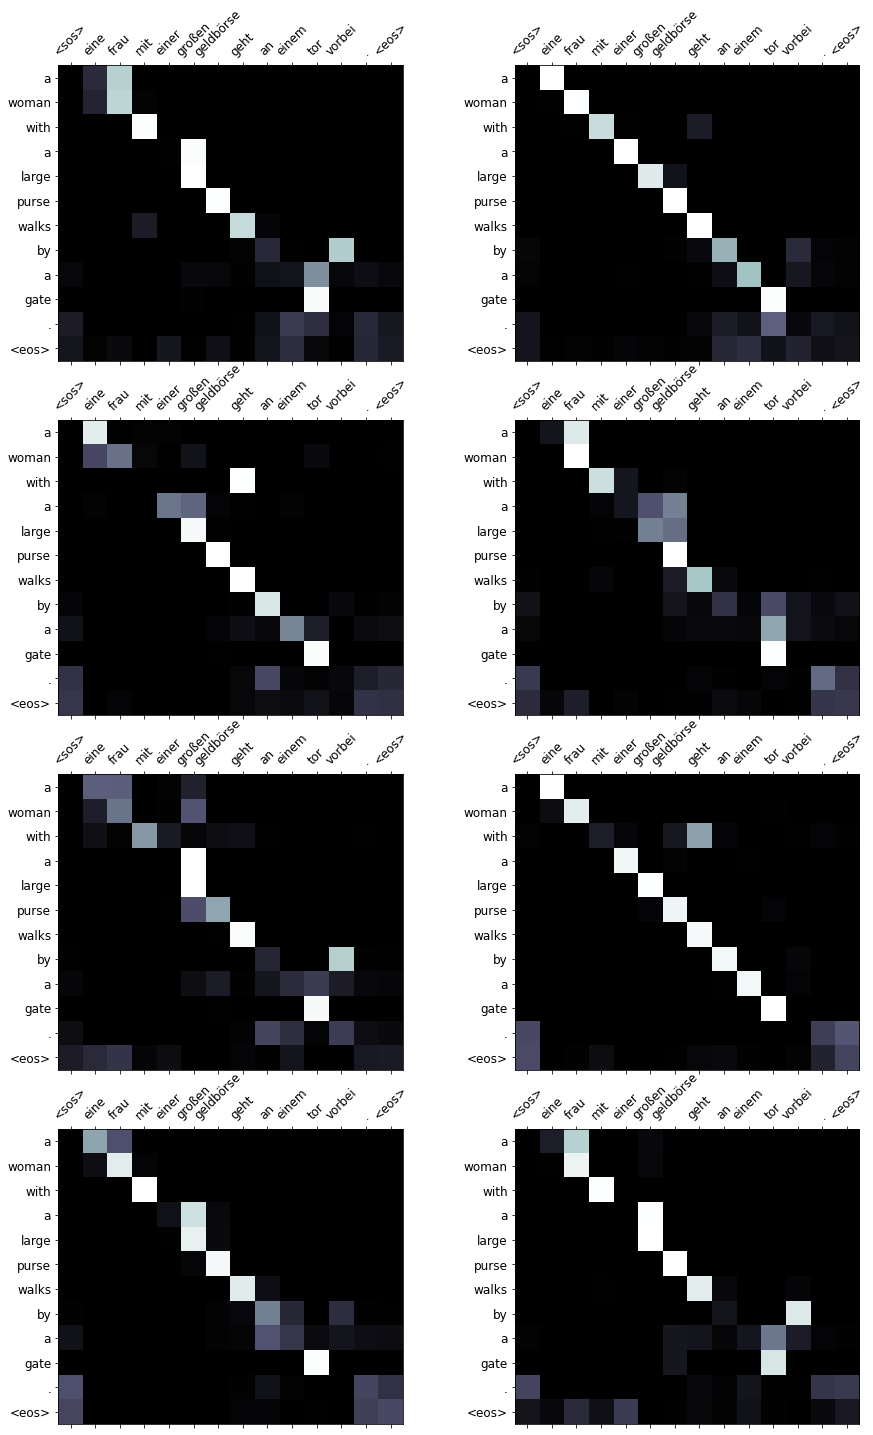

In [ ]:
display_attention(src, translation, attention)

validation 데이터셋의 예제를 번역


In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

<ipython-input-34-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-34-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


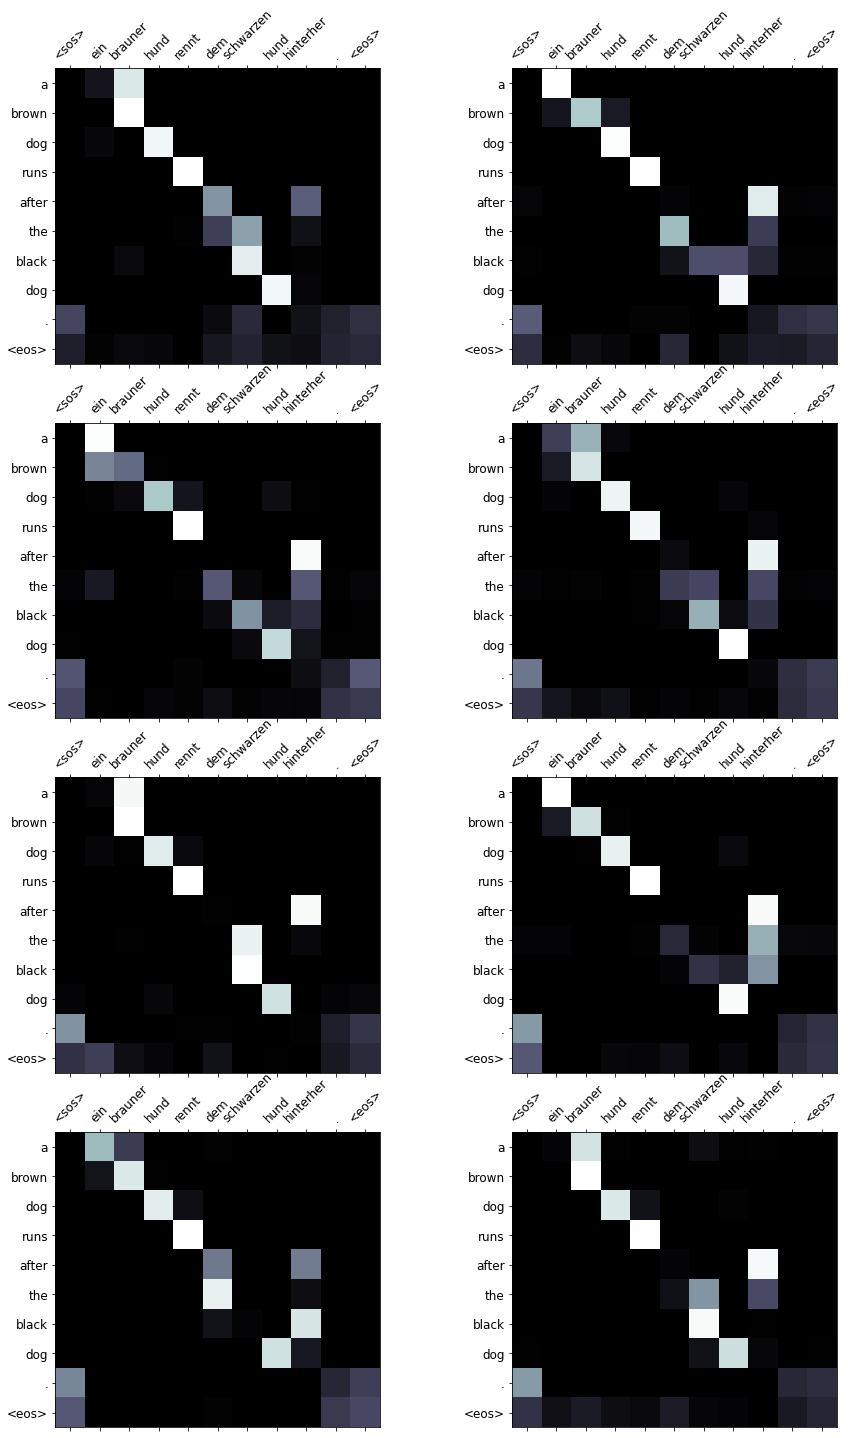

In [ ]:
display_attention(src, translation, attention)

Test 데이터셋의 예제를 번역

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A perfect translation!

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


<ipython-input-34-8546ab0d7ba0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-34-8546ab0d7ba0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


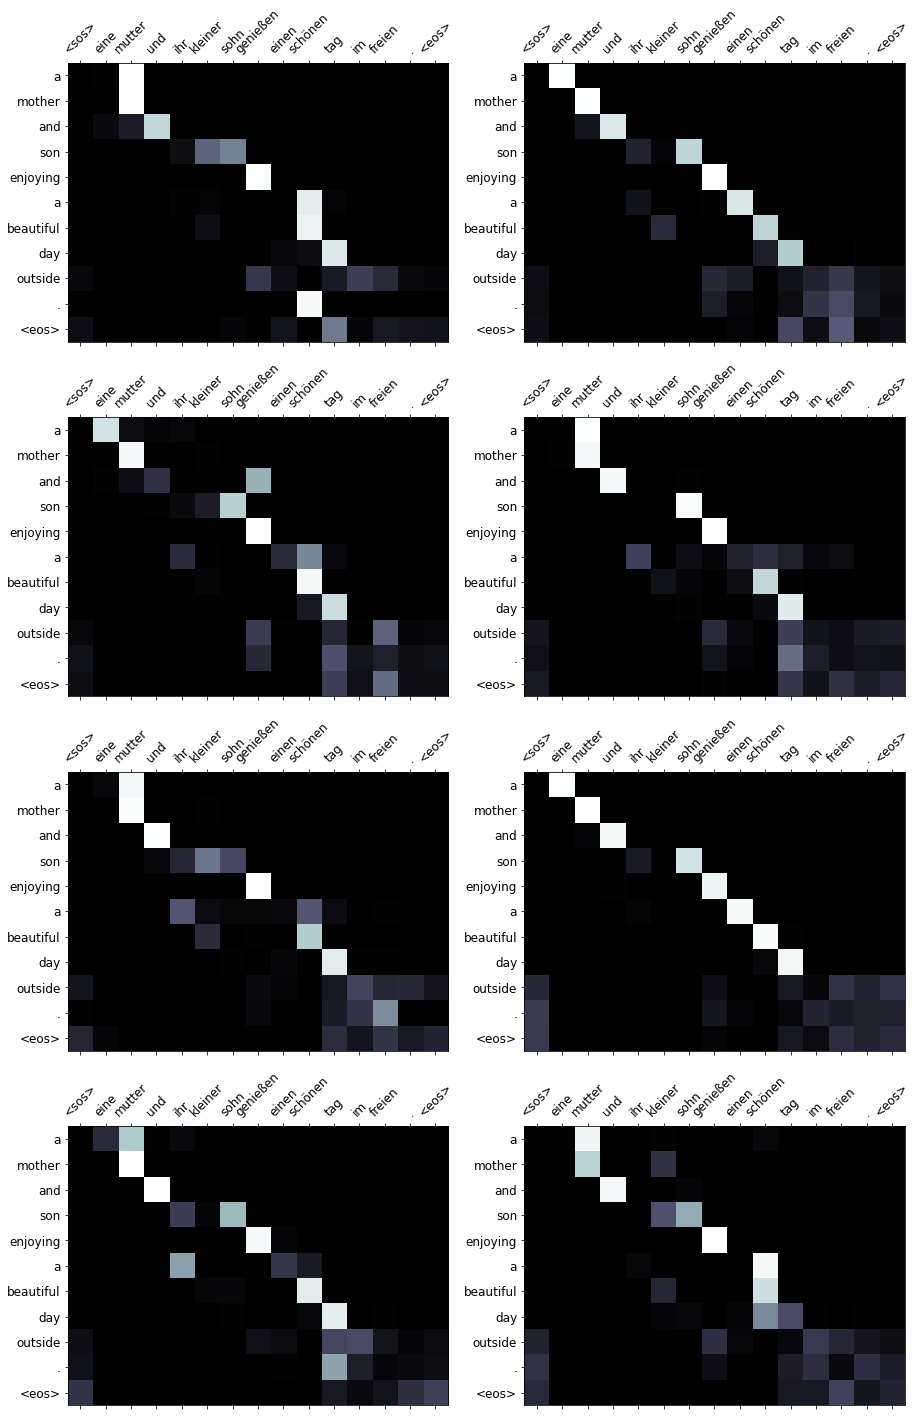

In [ ]:
display_attention(src, translation, attention)

## 입력받아 Test

## BLEU

BLEU 점수를 계산한다.
BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법으로 n-gram 기반이다

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

트랜스포머 모델의 BLEU 점수는 34.63이다.
RNN+어텐션 모델의 28점보다 높은 점수를 달성하면서도 병렬화가 잘 되어있어 학습 속도가 빠르다.

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 34.63


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [ ]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)